Main assignment 2: predicting customer engagement of Instagram posts using regression

# 1  Initialize Spark Environment

In [1]:
import findspark

import sys
import os
user = "Tom"
# Create SparkConf for the specified user
if user == "Tom":
    findspark.init("C:\Spark\spark-3.4.1-bin-hadoop3")
    import pyspark
    from pyspark import SparkConf, SparkContext
    from pyspark import sql
    from pyspark.sql import SparkSession
    config = SparkConf().setAll([
        ('spark.executor.memory', '8g'),
        ('spark.executor.cores', '10'),
        ('spark.cores.max', '8'),
        ('spark.driver.memory', '16g'),
        ('spark.network.timeout', '3600s'),
        ("spark.executor.heartbeatInterval", "3000s")
    ])
    config.setMaster("local[8]")
# # Create SparkContext using the specified SparkConf
sc = SparkContext(conf=config)

# # # Create SparkSession with the SparkContext
spark = SparkSession.builder.getOrCreate()

In [1]:
import findspark
import pyspark
from pyspark import SparkConf, SparkContext
from pyspark import sql
from pyspark.sql import SparkSession
import sys
import os
user = "Matteo"
# Create SparkConf for the specified user
if user == "Tom":
    findspark.init("C:\Spark\spark-3.4.1-bin-hadoop3")
    config = SparkConf().setAll([
        ('spark.executor.memory', '8g'),
        ('spark.executor.cores', '10'),
        ('spark.cores.max', '8'),
        ('spark.driver.memory', '16g'),
        ('spark.network.timeout', '3600s'),
        ("spark.executor.heartbeatInterval", "3000s")
    ])
    config.setMaster("local[8]")

elif user == "Matteo":
    findspark.init("C:\Spark\spark-3.5.0-bin-hadoop3")
    config = SparkConf().setAll([
        ('spark.executor.memory', '8g'),
        ('spark.executor.cores', '4'),
        ('spark.cores.max', '4'),
        ("spark.sql.shuffle.partitions", "4"),
        ('spark.driver.memory', '8g'),
        ("spark.executor.instances", "4"),
        ('spark.network.timeout', '3600s'),
    ])
    config.setMaster("local[6]")

elif user == "Julian":
    findspark.init('C:\\Users\\jaron\\Spark\\spark-3.5.0-bin-hadoop3')
    config = SparkConf().setAll([
        ('spark.executor.memory', '8g'),
        ('spark.executor.cores', '8'),
        ('spark.cores.max', '7'),
        ('spark.driver.memory', '16g'),
        ('spark.network.timeout', '3600s'),
        ("spark.executor.heartbeatInterval", "3000s")
    ])

elif user == "Yaël":
    sql.SparkSession.builder.master("local[*]")
    config = SparkConf().setAll([
        ("spark.executor.memory", "7g"),
        ('spark.yarn.am.memory', '7g'),
        ('spark.yarn.am.cores', '8'),
        ("spark.executor.cores", "8"),
        ('spark.driver.memory', '7g'),
        ('spark.cores.max', '8')
    ])
    sys.path.append('/Users/derockeryael/Documents/Master 2/Big Data/big_data_group_15')
    config.setAppName("x").setMaster("local[*]")
    # Add any additional configurations specific to Yaël's requirements

elif user == "Wannes":
    findspark.init("C:\Spark\spark-3.5.0-bin-hadoop3")
    config = pyspark.SparkConf().setAll([
        ("spark.executor.memory", "8g"),
        ("spark.executor.cores", "8"),
        ('spark.driver.memory', '8g'),
        ('spark.cores.max', '8')
    ]) 
    config.setMaster("local[4]")
# # Create SparkContext using the specified SparkConf
sc = SparkContext(conf=config)

# # # Create SparkSession with the SparkContext
spark = SparkSession.builder.getOrCreate()

In [2]:
# inspect spark session
spark

In [3]:
# import packages
import os 
import json
import lzma
from textblob import TextBlob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import re
from sklearn.cluster import KMeans

import pyspark.sql.functions as F
from pyspark.sql.functions import *
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import FloatType
from pyspark.sql.types import *
from pyspark.sql.window import Window
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from pyspark.sql.types import StructType, StructField, IntegerType, StringType
from pyspark import StorageLevel
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

import imutils
from mtcnn import MTCNN
import pytesseract
import cv2
import mtcnn
import os
import sys


# import pyspark ml packages
from pyspark.ml import Pipeline
from pyspark.ml.feature import *
from pyspark.ml.feature import Tokenizer, StopWordsRemover, Word2Vec, CountVectorizer, IDF
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.regression import LinearRegression, RandomForestRegressor, GBTRegressor, DecisionTreeRegressor,AFTSurvivalRegression
from pyspark.ml.evaluation import RegressionEvaluator

# 2 Preprocess & Load Data

Load in UDFs

In [4]:
# import required packages
from string import punctuation
from nltk.corpus import stopwords

# define puncutation and stopwords
PUNCTUATION = [char for char in punctuation if char not in ["!", "@", "#"]]
STOPWORDS = stopwords.words("english")

# define function to remove punctuation
def remove_punct(text):
    text = "".join([char for char in text if char not in PUNCTUATION])
    return(text)

# define function to remove stopwords
def remove_stops(text_tokenized):
    text_tokenized = [word for word in text_tokenized if word not in STOPWORDS]
    return(text_tokenized)



# # register functions as udf
remove_punct_UDF = F.udf(remove_punct, StringType())
remove_stops_UDF = F.udf(remove_stops, ArrayType(StringType()))


Read-in basetable

In [5]:
#read-in basetable
# Specify the path to the CSV file
csv_path = "../processed_data/singapore/merged_basetable_sin.csv"

pandas_df = pd.read_csv(csv_path, sep=",")

# Define the schema based on the provided column types
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, ArrayType, BooleanType, DoubleType, LongType, FloatType

schema = StructType([
    StructField("post_id", StringType(), nullable=False),
    StructField("text", StringType(), nullable=True),
    StructField("text_tokenized_no_stops", StringType(), nullable=True),
    StructField("num_words", IntegerType(), nullable=False),
    StructField("num_hashtags", IntegerType(), nullable=True),
    StructField("num_tags", IntegerType(), nullable=True),
    StructField("num_exclamation_marks", IntegerType(), nullable=True),
    StructField("num_question_marks", IntegerType(), nullable=True),
    StructField("is_event", BooleanType(), nullable=True),
    StructField("sentiment", DoubleType(), nullable=True),
    StructField("subjectivity", DoubleType(), nullable=True),
    StructField("contains_link", BooleanType(), nullable=True),
    StructField("at_in_text", IntegerType(), nullable=True),
    StructField("nr_emojis", IntegerType(), nullable=True),
    StructField("num_likes", LongType(), nullable=True),
    StructField("city", StringType(), nullable=True),
    StructField("country", StringType(), nullable=True),
    StructField("location", StringType(), nullable=True),
    StructField("time", StringType(), nullable=True),
    StructField("hour", IntegerType(), nullable=True),
    StructField("ad", IntegerType(), nullable=False),
    StructField("num_pictures", IntegerType(), nullable=True),
    StructField("video", IntegerType(), nullable=False),
    StructField("location_cat", IntegerType(), nullable=False),
    StructField("aspect_ratio", DoubleType(), nullable=True),
    StructField("city_bool", StringType(), nullable=True),
    StructField("country_bool", StringType(), nullable=True),
    StructField("num_comments", LongType(), nullable=True),
    StructField("time_top_post", IntegerType(), nullable=True),
    StructField("is_weekday", BooleanType(), nullable=True),
    StructField("part_of_day", StringType(), nullable=False),
    StructField("season", StringType(), nullable=False),
    StructField("vividness", StringType(), nullable=False),
    StructField("contains_city", BooleanType(), nullable=True),
    StructField("aspect_ratio_category", StringType(), nullable=True),
    StructField("num_followers", LongType(), nullable=True),
    StructField("colorfulness", FloatType(), nullable=True),
    StructField("face_count", IntegerType(), nullable=True),
    StructField("photo_has_text", IntegerType(), nullable=True),
    StructField("has_airplane", FloatType(), nullable=True),
    StructField("has_brand_logo", IntegerType(), nullable=True)
])

# Convert the modified Pandas DataFrame to a PySpark DataFrame
basetable = spark.createDataFrame(pandas_df, schema=schema)

# Re-Create the text_tokenized_no_stops column
basetable = basetable.withColumn("text_lower", F.lower("text")) \
                                 .withColumn("text_cleaned", remove_punct_UDF("text_lower")) \
                                 .withColumn("text_tokenized", F.split("text_cleaned", " ")) \
                                 .withColumn("text_tokenized_no_stops", remove_stops_UDF("text_tokenized")) \
                                 .drop("text_lower") \
                                 .drop("text_cleaned") \
                                 .drop("text_tokenized")

basetable = basetable.na.drop(subset=["time_top_post", "num_followers"])

# Show the DataFrame schema and some sample data
basetable.printSchema()
basetable.show()

root
 |-- post_id: string (nullable = false)
 |-- text: string (nullable = true)
 |-- text_tokenized_no_stops: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- num_words: integer (nullable = false)
 |-- num_hashtags: integer (nullable = true)
 |-- num_tags: integer (nullable = true)
 |-- num_exclamation_marks: integer (nullable = true)
 |-- num_question_marks: integer (nullable = true)
 |-- is_event: boolean (nullable = true)
 |-- sentiment: double (nullable = true)
 |-- subjectivity: double (nullable = true)
 |-- contains_link: boolean (nullable = true)
 |-- at_in_text: integer (nullable = true)
 |-- nr_emojis: integer (nullable = true)
 |-- num_likes: long (nullable = true)
 |-- city: string (nullable = true)
 |-- country: string (nullable = true)
 |-- location: string (nullable = true)
 |-- time: string (nullable = true)
 |-- hour: integer (nullable = true)
 |-- ad: integer (nullable = false)
 |-- num_pictures: integer (nullable = true)
 |-- video: intege

In [6]:
# convert features to correct data type
basetable = basetable.withColumn("num_words", F.col("num_words").cast(DoubleType())) \
                    .withColumn("num_hashtags", F.col("num_hashtags").cast(DoubleType())) \
                    .withColumn("num_tags", F.col("num_tags").cast(DoubleType())) \
                    .withColumn("num_exclamation_marks", F.col("num_exclamation_marks").cast(DoubleType())) \
                    .withColumn("num_question_marks", F.col("num_question_marks").cast(DoubleType())) \
                    .withColumn("is_event", F.col("is_event").cast(StringType())) \
                    .withColumn("contains_link", F.col("contains_link").cast(StringType())) \
                    .withColumn("at_in_text", F.col("at_in_text").cast(IntegerType())) \
                    .withColumn("num_likes", F.col("num_likes").cast(DoubleType())) \
                    .withColumn("hour", F.col("hour").cast(DoubleType())) \
                    .withColumn("ad", F.col("ad").cast(DoubleType())) \
                    .withColumn("num_pictures", F.col("num_pictures").cast(DoubleType())) \
                    .withColumn("video", F.col("video").cast(DoubleType())) \
                    .withColumn("is_weekday", F.col("is_weekday").cast(StringType())) \
                    .withColumn("time_top_post", F.col("time_top_post").cast(DoubleType())) \
                    .withColumn("contains_city", F.col("contains_city").cast(DoubleType())) \
                    .withColumn("num_comments", F.col("num_comments").cast(DoubleType()))\
                    .withColumn("colorfulness", F.col("colorfulness").cast(DoubleType()))\
                    .withColumn("face_count", F.col("face_count").cast(DoubleType()))\
                    .withColumn("photo_has_text", F.col("photo_has_text").cast(DoubleType()))\
                    .withColumn("nr_emojis", F.col("nr_emojis").cast(DoubleType()))\
                    .withColumn("city_bool", F.col("city_bool").cast(DoubleType()))\
                    .withColumn("country_bool", F.col("country_bool").cast(DoubleType()))\
                    .withColumn("location_cat", F.col("location_cat").cast(DoubleType()))
               
                    
                    
                    

## Create one-hot encoded variables 

In [7]:
# create one-hot encoded variables 

# Use the withColumn method to create a new column 'is_event_numeric'
basetable = basetable.withColumn(
    'is_event_numeric',
    F.when(basetable['is_event'] == 'true', 1).otherwise(0)
)

# Use the withColumn method to create a new column 'is_event_numeric'
basetable = basetable.withColumn(
    'contains_link_numeric',
    F.when(basetable['contains_link'] == 'true', 1).otherwise(0)
)

# Get distinct values in the 'part_of_day' column
distinct_values = [row.vividness for row in basetable.select('vividness').distinct().collect()]

# Create dummy variables for each distinct value
for value in distinct_values:
    condition = (F.col("vividness") == value).cast("int").alias(value)
    basetable = basetable.withColumn(value+"_vividness", condition)
distinct_values


# Get distinct values in the 'part_of_day' column
distinct_values = [row.part_of_day for row in basetable.select('part_of_day').distinct().collect()]

# Create dummy variables for each distinct value
for value in distinct_values:
    condition = (F.col("part_of_day") == value).cast("int").alias(value)
    basetable = basetable.withColumn(value, condition)


# Get distinct values in the 'aspect_ratio_category' column
distinct_values = [row.aspect_ratio_category for row in basetable.select('aspect_ratio_category').distinct().collect()]

# Create dummy variables for each distinct value
for value in distinct_values:
    condition = (F.col("aspect_ratio_category") == value).cast("int").alias(value)
    basetable = basetable.withColumn(value, condition)


# Define conditions for each season
spring_condition = (F.col("season") == "Spring").cast("int").alias("Spring")
summer_condition = (F.col("season") == "Summer").cast("int").alias("Summer")
fall_condition = (F.col("season") == "Fall").cast("int").alias("Fall")
winter_condition = (F.col("season") == "Winter").cast("int").alias("Winter")

# Use the 'withColumn' method to create dummy variables
basetable = basetable.withColumn("Spring", spring_condition)
basetable = basetable.withColumn("Summer", summer_condition)
basetable = basetable.withColumn("Fall", fall_condition)

basetable.cache()
basetable.count()


1781

In [ ]:
from pyspark.sql.functions import col, sum, isnan

# Columns to exclude from the check
exclude_columns = ["text", "text_tokenized_no_stops"]

for col_name in basetable.columns:
    # Skip the columns in the exclusion list
    if col_name in exclude_columns:
        continue

    # Check for null, empty string, and NaN values
    missing_count = basetable.filter(
        col(col_name).isNull() | (col(col_name) == "") | isnan(col(col_name))
    ).count()
    
    missing_percentage = (missing_count / basetable.count()) * 100
    print(f"{col_name}: Missing Count = {missing_count}, Missing Percentage = {missing_percentage:.2f}%")

# 3 Modeling

## 3.1 Engagement variable creation & train/test set creation

Distancing of Engagement

In [8]:
# Assuming basetable_luf and basetable_sin are your DataFrames
basetable = basetable \
    .withColumn("post_date", to_date(substring(col("post_id"), 1, 7), "yyyy-MM")) \
    .filter(col("post_date") > lit("2016-08")) \
    .drop("post_date")

In [9]:
# Calculate the 'engagement' column
basetable = basetable.withColumn(
    "engagement",
    100 * (F.col("num_comments") + F.col("num_likes")) / F.col("num_followers")) \
    .withColumn("post_date", to_date(substring(col("post_id"), 1, 10), "yyyy-MM-dd"))

# Create a window specification for ordering
windowSpec = Window().orderBy("post_date")

# Calculate the difference between consecutive 'engagement' values
basetable = basetable.withColumn(
    "engagement_difference",
    F.col("engagement") - F.lag("engagement").over(windowSpec)
)

# Remove first row (no difference)
basetable = basetable.filter(F.col("engagement_difference").isNotNull())

# Show the resulting DataFrame
basetable.cache()
basetable.show()

+--------------------+--------------------+-----------------------+---------+------------+--------+---------------------+------------------+--------+---------+------------------+-------------+----------+---------+---------+----+-------+--------+-------------------+----+---+------------+-----+------------+------------------+---------+------------+------------+-------------+----------+-----------+------+---------+-------------+---------------------+-------------+------------------+----------+--------------+------------+--------------+----------------+---------------------+--------------+-------------+----------------+-------+---------+-----+-------+---------+--------+------+------+------+----+-------------------+----------+---------------------+
|             post_id|                text|text_tokenized_no_stops|num_words|num_hashtags|num_tags|num_exclamation_marks|num_question_marks|is_event|sentiment|      subjectivity|contains_link|at_in_text|nr_emojis|num_likes|city|country|location| 

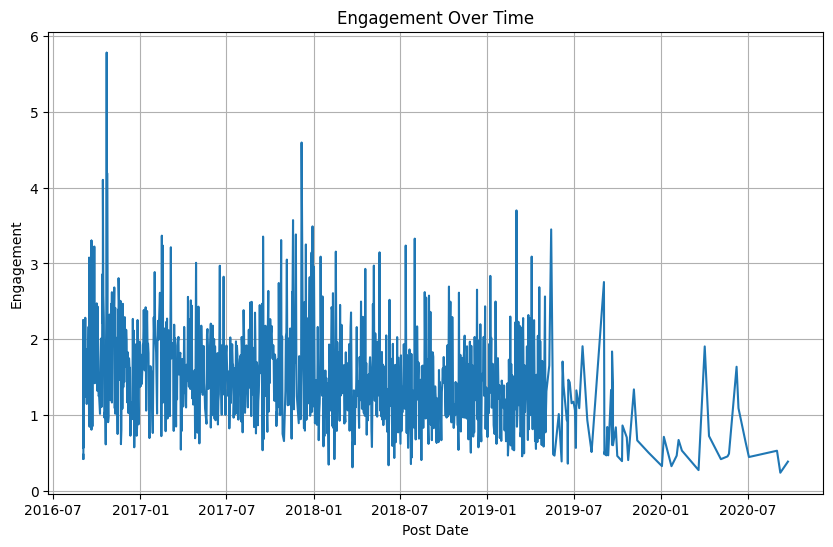

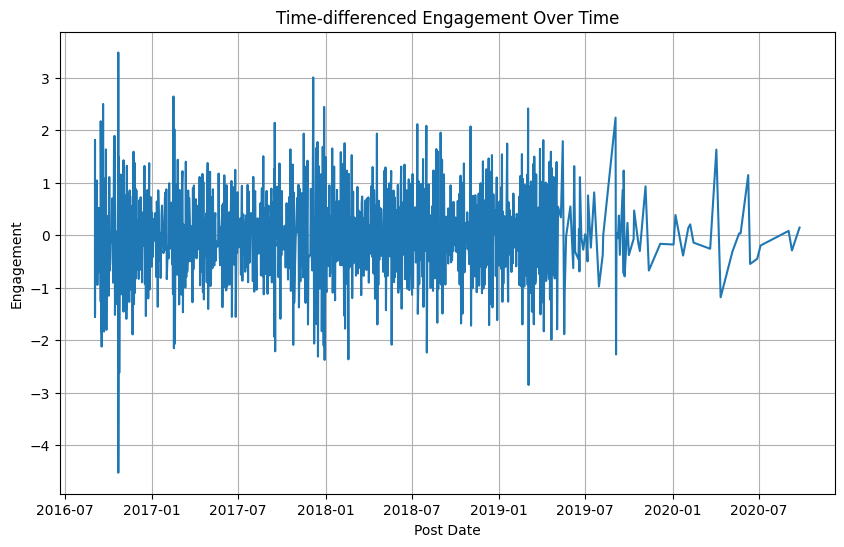

In [10]:
# visualize
test = basetable.toPandas()
test['post_date'] = pd.to_datetime(test['post_date'])

# Sort the DataFrame by 'post_date' for a chronological plot
test = test.sort_values('post_date')

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(test['post_date'], test['engagement'], linestyle='-')
plt.title('Engagement Over Time')
plt.xlabel('Post Date')
plt.ylabel('Engagement')
plt.grid(True)
plt.show()
plt.figure(figsize=(10, 6))
plt.plot(test['post_date'], test['engagement_difference'], linestyle='-')
plt.title('Time-differenced Engagement Over Time')
plt.xlabel('Post Date')
plt.ylabel('Engagement')
plt.grid(True)
plt.show()

In [11]:
# vector indexer and string indexer should be performed on the entire dataset 
# define categorical variables
cat_var =['is_event', 'contains_link','at_in_text','city_bool','country_bool','contains_city',
           'is_weekday','has_airplane','has_brand_logo',"season", "part_of_day", "vividness", "location_cat", "aspect_ratio_category"]

# ['is_event', 'contains_link','at_in_text','city_bool','country_bool','contains_city',
#            'photo_has_text','has_airplane','has_brand_logo']

# define indexed cat var
cat_var_idx = [name + "_idx" for name in cat_var]
# define the indexer
CAT_IDX = StringIndexer(inputCols=cat_var, outputCols=cat_var_idx)
# define the assembler
CAT_VA = VectorAssembler(inputCols=cat_var_idx, outputCol="cat_features_idx")

In [12]:
# define pipeline stages
stages = [CAT_IDX, CAT_VA]
# define pipeline model and fit on data
pipeline_model_preprocess = Pipeline().setStages(stages).fit(basetable)
# transform data by applying pipeline model on data
basetable_preprocessed = pipeline_model_preprocess.transform(basetable)
basetable_preprocessed.show(5, truncate=False)

+-----------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------+------------+--------+---------------------+------------------+--------+---------+------------+-------------+----------+---------+---------+----+-------+--------+-------------------+----+---+------------+-----+------------+------------------+---------+------------+------------+-------------+----------+-----------+------+---------+-------------+---------------------+-------------+------------------+----------+--------------+------------+--------------+----------------+---------------------+--------------+-------------+----------------+-------+---------+-----+-------+---------+---

#### Train/test split 

Make use of a time based split given that there are non-stationarities. 

In [13]:
# Sort the DataFrame by 'post_id'
basetable_preprocessed = basetable_preprocessed.orderBy("post_id")

# Calculate the total number of rows
total_rows = basetable_preprocessed.count()

# Calculate the number of rows for the train and test sets
train_rows = int(total_rows * 0.8)
test_rows = total_rows - train_rows

# Create a window specification for adding row numbers
window_spec = Window.orderBy(col("post_id"))

# Add a row number column to the DataFrame
basetable_preprocessed = basetable_preprocessed.withColumn("row_number", F.row_number().over(window_spec))

# Split the DataFrame into train and test sets
train = basetable_preprocessed.filter(col("row_number") <= train_rows)
test = basetable_preprocessed.filter(col("row_number") > train_rows)

# Drop the row_number column from the train and test sets
train = train.drop("row_number")
test = test.drop("row_number")

In [14]:
# write data to csv as input for colab
train_colab= train.toPandas()
test_colab= test.toPandas()

# write to csv files for autogluon in colab 
train_path = "../processed_data/singapore/input_colab/train_data.csv"
test_path = "../processed_data/singapore/input_colab/test_data.csv"

train_colab.to_csv(train_path, index=False)
test_colab.to_csv(test_path, index=False)

In [15]:
# get  engagement
engagement = train.select("engagement").toPandas()
# check engagement stats
print("mean: %s" %np.mean(engagement["engagement"]))
print("std: %s" %np.std(engagement["engagement"]))
print("median: %s" %np.median(engagement["engagement"]))
print("third quartile: %s" %np.percentile(engagement["engagement"], 75))

mean: 1.5374963261872132
std: 0.6445889473534563
median: 1.4582153314314494
third quartile: 1.913382457942856


In [16]:
# get  difference_engagement
engagement = train.select("engagement_difference").toPandas()
# check engagement stats
print("mean: %s" %np.mean(engagement["engagement_difference"]))
print("std: %s" %np.std(engagement["engagement_difference"]))
print("median: %s" %np.median(engagement["engagement_difference"]))
print("third quartile: %s" %np.percentile(engagement["engagement_difference"], 75))

mean: 0.00010037623128532847
std: 0.8772357505045655
median: 0.005794719769428358
third quartile: 0.5716056505035633


#### Feature selection using sci-kit learn as PySpark does not support it at the moment of writing

In [ ]:
# define categorical variables
cat_var = ['is_event','contains_link','at_in_text','location_cat','city_bool','country_bool',
           'season', 'part_of_day','contains_city','aspect_ratio_category',
           'photo_has_text','has_airplane','has_brand_logo','vividness']
# define numeric variables
num_var = ['num_words',
           'num_hashtags',
           'num_tags',
           'num_exclamation_marks',
           'num_question_marks',
           'sentiment',
          'subjectivity',
          'colorfulness',
          'nr_emojis',
          'num_pictures',
          'face_count', 
           'time_top_post'
          ]

In [ ]:
train_pandas = train.toPandas()
test_pandas = test.toPandas()

# Extract features and target variable
X_train = train_pandas[cat_var + num_var]
y_train = train_pandas['engagement']

# # Convert categorical variables to dummy variables
X_train = pd.get_dummies(X_train, columns=cat_var, drop_first=True)

# Import necessary libraries
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestRegressor 

# Create the model for RFE
model = RandomForestRegressor()

min_features_to_select = 1
# Create the RFECV object
rfecv = RFECV(
    estimator=model,
    step=1,
    min_features_to_select=min_features_to_select,
    cv=15,
    scoring='neg_mean_squared_error',
    verbose=1,
    importance_getter="feature_importances_"
)

# Fit the RFECV object to the data
rfecv.fit(X_train, y_train)

# Get the selected features
selected_features = X_train.columns[rfecv.support_]

# Print the selected features
print("Selected Features:", selected_features)

In [19]:
# Get the feature ranking
feature_ranking = rfecv.ranking_

# Create a DataFrame to display the features and their rankings
feature_ranking_df = pd.DataFrame({'Feature': X_train.columns, 'Ranking': feature_ranking})

# Sort the DataFrame by ranking
feature_ranking_df = feature_ranking_df.sort_values(by='Ranking')

# Print the sorted DataFrame
print(f"Number of features: {len(selected_features)}")
print("Selected Features:", selected_features)
print("Feature Ranking:")
print(feature_ranking_df)

Number of features: 14
Selected Features: Index(['num_words', 'num_hashtags', 'num_tags', 'num_exclamation_marks',
       'sentiment', 'subjectivity', 'colorfulness', 'time_top_post',
       'at_in_text_1.0', 'country_bool_1', 'season_Winter',
       'aspect_ratio_category_square', 'has_airplane_1.0', 'vividness_Low'],
      dtype='object')
Feature Ranking:
                           Feature  Ranking
0                        num_words        1
1                     num_hashtags        1
2                         num_tags        1
3            num_exclamation_marks        1
17                  country_bool_1        1
5                        sentiment        1
6                     subjectivity        1
7                     colorfulness        1
28                has_airplane_1.0        1
30                   vividness_Low        1
20                   season_Winter        1
11                   time_top_post        1
26    aspect_ratio_category_square        1
14                  at_i

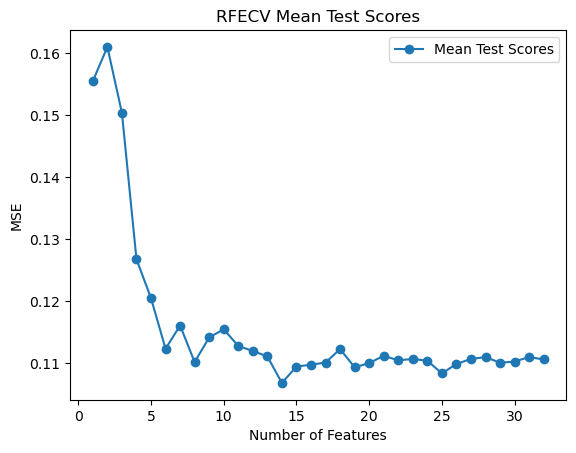

In [20]:
# Generating x-axis values (e.g., the number of features in your case)
# Replace the following line with the appropriate x-axis values for your plot
num_features = range(1, len(rfecv.cv_results_["mean_test_score"]) + 1)

# Plotting the mean test scores with error bars (standard deviation)
plt.errorbar(num_features, -1*rfecv.cv_results_["mean_test_score"], fmt='o-', label='Mean Test Scores')

# Adding labels and title
plt.xlabel('Number of Features')
plt.ylabel('MSE')
plt.title('RFECV Mean Test Scores')

# Displaying the plot
plt.legend()
plt.show()

As we get a different set of features each time, we choose not to go further with this implementation

# 3.2 Pipeline set-up continued

In [17]:
dependent_variable = "engagement"

In [18]:
num_var = ['num_words',
            'num_hashtags',
            'num_tags',
            'num_exclamation_marks',
            'num_question_marks',
            'sentiment',
            'subjectivity',
            'colorfulness',
            'nr_emojis',
            'num_pictures',
            'face_count', 
            'time_top_post']


# define the vector assembler
NUM_AS = VectorAssembler(inputCols=num_var, outputCol="num_features")
# define the scaler
NUM_SC = StandardScaler(inputCol="num_features", outputCol="num_features_scaled")

# define word2vec
W2V = Word2Vec(inputCol="text_tokenized_no_stops", outputCol="text_features")

# define final assembler
AS = VectorAssembler(inputCols=["cat_features_idx","num_features_scaled", "text_features"], outputCol="features")

In [19]:
# define pipeline model stages
stages = [NUM_AS, NUM_SC,W2V, AS]
# define pipeline model
pipeline_model_split = Pipeline().setStages(stages)
# fit pipeline model on training data
pipeline_model_split = pipeline_model_split.fit(train)
# transform training set
train_final = pipeline_model_split.transform(train).select([dependent_variable, "features"])
# transform test set
test_final = pipeline_model_split.transform(test).select([dependent_variable, "features"])

## 3.3 Machine Learning Models

### 3.3.1 Linear Regression

In [22]:
LR = LinearRegression(featuresCol="features", labelCol=dependent_variable)

# Create the parameter grid
paramGrid = ParamGridBuilder() \
    .addGrid(LR.regParam, [0,0.1]) \
    .addGrid(LR.elasticNetParam, [1]).build()

# Create a CrossValidator object with the specified settings
crossval_LR = CrossValidator(estimator=LR,
                             estimatorParamMaps=paramGrid,
                             evaluator=RegressionEvaluator(labelCol=dependent_variable),
                             numFolds=5,
                             parallelism=1,
                             seed=1234
                             )
# Run cross-validation on your training data and choose the best set of hyperparameters
cvModel_LR = crossval_LR.fit(train_final)

In [23]:
# Get the cross-validation results
cv_results = cvModel_LR.avgMetrics

# Convert cv_results to a numpy array
cv_results_array = np.array(cv_results)

# Find the index of the best model's score in cv_results
best_model_index = np.argmin(cv_results_array)

# Get the corresponding hyperparameters from paramGrid
best_params = paramGrid[best_model_index]

# Get the cross-validation score of the best model
best_cv_score = cv_results[best_model_index]

# Assuming `best_model` is the best model obtained from cross-validation
best_model_LR = cvModel_LR.bestModel

print("Cross-validation score (RMSE) of the best model:", best_cv_score)
print("Hyperparameters of the best model:")
for param, value in best_params.items():
    print(f"{param.name}: {value}")

Cross-validation score (RMSE) of the best model: 0.5165071594406168
Hyperparameters of the best model:
regParam: 0.0
elasticNetParam: 1.0


### 3.3.2 Decision Tree 

In [24]:
DT_1 = DecisionTreeRegressor(featuresCol="features", labelCol=dependent_variable)

# Define a grid of hyperparameters to search over
# Grid is based on https://arxiv.org/abs/1812.02207

# maxDepth ranges from 5 to 30, as per the paper's suggestion.
# minInstancesPerNode is given a range from 1 to 50.

# # Create the parameter grid
# paramGrid = ParamGridBuilder() \
#     .addGrid(DT_1.maxDepth, [3,5,8,15,20,30]) \
#     .addGrid(DT_1.minInstancesPerNode, [1, 5, 10, 25,50, 100]) \
#     .addGrid(DT_1.minInfoGain, [0.0, 0.1]) \
#     .addGrid(DT_1.maxBins, [16,32]).build()

# Create the parameter grid
paramGrid = ParamGridBuilder() \
    .addGrid(DT_1.maxDepth, [3]) \
    .addGrid(DT_1.minInstancesPerNode, [50,]) \
    .addGrid(DT_1.minInfoGain, [0]) \
    .addGrid(DT_1.maxBins, [16]).build()

# Create a CrossValidator object with the specified settings
crossval_DT = CrossValidator(estimator=DT_1,
                             estimatorParamMaps=paramGrid,
                             evaluator=RegressionEvaluator(labelCol=dependent_variable),
                             numFolds=5,
                             parallelism=1,
                             seed=1234
                             )
# Run cross-validation on your training data and choose the best set of hyperparameters
cvModel_DT = crossval_DT.fit(train_final)

In [25]:
# Get the cross-validation results
cv_results = cvModel_DT.avgMetrics

# Convert cv_results to a numpy array
cv_results_array = np.array(cv_results)

# Find the index of the best model's score in cv_results
best_model_index = np.argmin(cv_results_array)

# Get the corresponding hyperparameters from paramGrid
best_params = paramGrid[best_model_index]

# Get the cross-validation score of the best model
best_cv_score = cv_results[best_model_index]

# Assuming `best_model` is the best model obtained from cross-validation
best_model_DT = cvModel_DT.bestModel

print("Cross-validation score (RMSE) of the best model:", best_cv_score)
print("Hyperparameters of the best model:")
for param, value in best_params.items():
    print(f"{param.name}: {value}")

Cross-validation score (RMSE) of the best model: 0.5616338053222184
Hyperparameters of the best model:
maxDepth: 3
minInstancesPerNode: 50
minInfoGain: 0.0
maxBins: 16


### 3.3.3 Random Forest

In [26]:
RF_1 = RandomForestRegressor(featuresCol="features", labelCol=dependent_variable)


# Define a grid of hyperparameters to search over
# Grid is based on https://spark.apache.org/docs/3.5.0/mllib-ensembles.html#gradient-boosted-trees-vs-random-forests

# featureSubsetStrategy is related to mtry: root p or p/3 has empirically best results
# subsamplingRate is related to sample size: lower sample size has the same effect as mtry parameter
# minInstancesPerNode is related to the minimum number of observations in a terminal node, 5 for regression it provides good results. This is also related to maxDepth
# Number of trees needs to be set high enough, is not really tunable
paramGrid = ParamGridBuilder() \
    .addGrid(RF_1.featureSubsetStrategy, ["onethird"]) \
    .addGrid(RF_1.subsamplingRate, [0.5,0.75,1]) \
    .addGrid(RF_1.minInstancesPerNode, [1,5,10]) \
    .addGrid(RF_1.maxDepth, [3,5,7]) \
    .addGrid(RF_1.numTrees, [150]) \
    .build()


# Create a CrossValidator object with the specified settings
crossval_RF = CrossValidator(estimator=RF_1,
                             estimatorParamMaps=paramGrid,
                             evaluator=RegressionEvaluator(labelCol=dependent_variable),
                             numFolds=5,
                             parallelism=1,
                             seed=1234
                             )
# Run cross-validation on your training data and choose the best set of hyperparameters
cvModel_RF = crossval_RF.fit(train_final)

In [27]:
# Get the cross-validation results
cv_results = cvModel_RF.avgMetrics

# Convert cv_results to a numpy array
cv_results_array = np.array(cv_results)


# Find the index of the best model's score in cv_results
best_model_index = np.argmin(cv_results_array)


# Get the corresponding hyperparameters from paramGrid
best_params = paramGrid[best_model_index]

# Get the cross-validation score of the best model
best_cv_score = cv_results[best_model_index]

# Assuming `best_model` is the best model obtained from cross-validation
best_model_RF = cvModel_RF.bestModel

print("Cross-validation score (RMSE) of the best model:", best_cv_score)
print("Hyperparameters of the best model:")
for param, value in best_params.items():
    print(f"{param.name}: {value}")

Cross-validation score (RMSE) of the best model: 0.5149235777806489
Hyperparameters of the best model:
featureSubsetStrategy: onethird
subsamplingRate: 1.0
minInstancesPerNode: 1
maxDepth: 7
numTrees: 150


### 3.3.4 Gradient Boosted Regressor

In [28]:
# Define your RandomForestRegressor model with specified features and label columns
GBT_1 = GBTRegressor(featuresCol="features", labelCol=dependent_variable)

# # Create the parameter grid
# paramGrid = ParamGridBuilder() \
#     .addGrid(GBT_1.maxDepth, [2, 4, 6]) \
#     .addGrid(GBT_1.maxIter, [5,10,30,50,100]) \
#     .addGrid(GBT_1.stepSize, [0.1]) \
#     .addGrid(GBT_1.maxBins, [32]).build()


# Create the parameter grid
paramGrid = ParamGridBuilder() \
    .addGrid(GBT_1.maxDepth, [2]) \
    .addGrid(GBT_1.maxIter, [50]) \
    .addGrid(GBT_1.stepSize, [0.1]) \
    .addGrid(GBT_1.maxBins, [32]).build()

# Create a CrossValidator object with the specified settings
crossval_GBT = CrossValidator(estimator=GBT_1,
                             estimatorParamMaps=paramGrid,
                             evaluator=RegressionEvaluator(labelCol=dependent_variable),
                             numFolds=5,
                             parallelism=1,
                             seed=1234
                             )

# Run cross-validation on your training data and choose the best set of hyperparameters
cvModel_GBT = crossval_GBT.fit(train_final)

In [29]:
# Get the cross-validation results
cv_results = cvModel_GBT.avgMetrics

# Convert cv_results to a numpy array
cv_results_array = np.array(cv_results)

# Find the index of the best model's score in cv_results
best_model_index = np.argmin(cv_results_array)

# Get the corresponding hyperparameters from paramGrid
best_params = paramGrid[best_model_index]

# Get the cross-validation score of the best model
best_cv_score = cv_results[best_model_index]

# Assuming `best_model` is the best model obtained from cross-validation
best_model_GBT = cvModel_GBT.bestModel

print("Cross-validation score (RMSE) of the best model:", best_cv_score)
print("Hyperparameters of the best model:")
for param, value in best_params.items():
    print(f"{param.name}: {value}")

Cross-validation score (RMSE) of the best model: 0.5243074220321655
Hyperparameters of the best model:
maxDepth: 2
maxIter: 50
stepSize: 0.1
maxBins: 32


## 3.4 Determine best model and score on test data 

In [30]:
Evaluator = RegressionEvaluator(predictionCol="prediction", labelCol=dependent_variable)

In [31]:
RFpredictions = best_model_RF.transform(test_final)

# Calculate evaluation metrics for Random Forest predictions
RFsq = Evaluator.evaluate(RFpredictions, {Evaluator.metricName: 'r2'})
RFmae = Evaluator.evaluate(RFpredictions, {Evaluator.metricName: 'mae'})
RFmse = Evaluator.evaluate(RFpredictions, {Evaluator.metricName: 'rmse'})
RFrmse = Evaluator.evaluate(RFpredictions, {Evaluator.metricName: 'mse'})

# Print each of these scores for Random Forest
print(f"R-squared (R2) for Random Forest: {RFsq}")
print(f"Mean Absolute Error (MAE) for Random Forest: {RFmae}")
print(f"Root Mean Squared Error (RMSE) for Random Forest: {RFmse}")
print(f"Mean Squared Error (MSE) for Random Forest: {RFrmse}")

R-squared (R2) for Random Forest: 0.16932600620442428
Mean Absolute Error (MAE) for Random Forest: 0.4799359235351784
Root Mean Squared Error (RMSE) for Random Forest: 0.5795466775489629
Mean Squared Error (MSE) for Random Forest: 0.3358743514580417


In [32]:
# Assuming `test_data` is your test dataset
predictions = best_model_RF.transform(test_final)
# Show the predictions
predictions.show(500)

+-------------------+--------------------+------------------+
|         engagement|            features|        prediction|
+-------------------+--------------------+------------------+
| 1.4599986335997814|[0.0,0.0,1.0,0.0,...|1.2826938449630794|
| 1.2322165862863514|[0.0,0.0,0.0,0.0,...|1.8769094809325426|
| 1.6790240265233038|[0.0,0.0,0.0,0.0,...|2.0375403262782465|
| 1.1886974586099395|[0.0,0.0,0.0,0.0,...| 1.751612456576921|
| 2.6535476260976356|[0.0,0.0,0.0,0.0,...| 2.018814728250324|
| 0.9411278797621149|[0.0,0.0,0.0,0.0,...|1.3059888373888564|
| 1.6865997668446961|[0.0,0.0,0.0,0.0,...|1.8034209554308223|
| 0.5732216157152458|[0.0,1.0,1.0,0.0,...|1.2778491439532855|
| 0.7753584910397762|[0.0,1.0,1.0,0.0,...| 1.229380650302075|
| 1.9871982192852258|[0.0,0.0,0.0,0.0,...|1.8773926707091524|
| 0.6684298832462962|[0.0,1.0,1.0,0.0,...| 1.329796589422157|
| 2.1973413362574785|[0.0,0.0,1.0,0.0,...|2.1953561701665487|
|  0.822392594720203|[0.0,0.0,1.0,0.0,...|1.2575457297366563|
| 0.6517

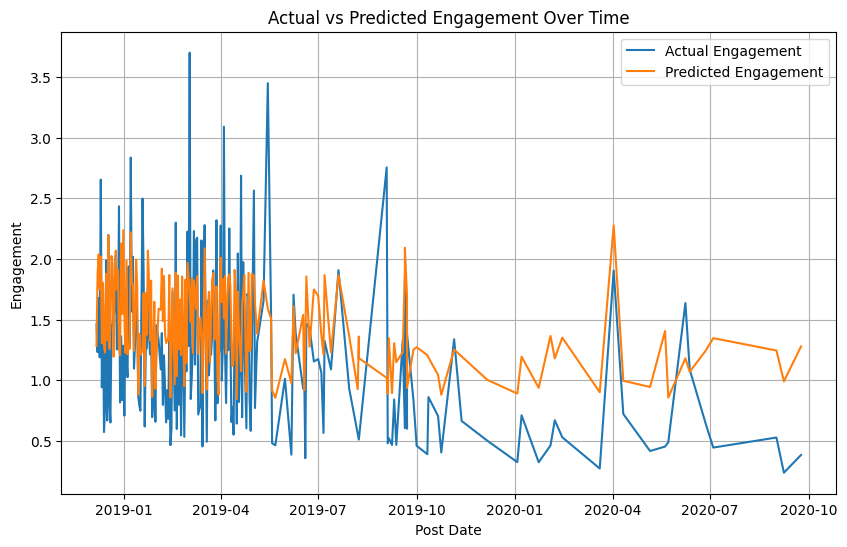

In [33]:
test_pd = test.toPandas()
test_pd['post_date'] = pd.to_datetime(test_pd['post_date'])
preds = predictions.select("prediction").toPandas()
# Merge on index
merged_data = pd.merge(test_pd, preds, left_index=True, right_index=True)

# Scatter Plotting
plt.figure(figsize=(10, 6))
plt.plot(merged_data['post_date'], merged_data['engagement'], label='Actual Engagement')
plt.plot(merged_data['post_date'], merged_data['prediction'], label='Predicted Engagement')
plt.title('Actual vs Predicted Engagement Over Time')
plt.xlabel('Post Date')
plt.ylabel('Engagement')
plt.legend()
plt.grid(True)
plt.show()

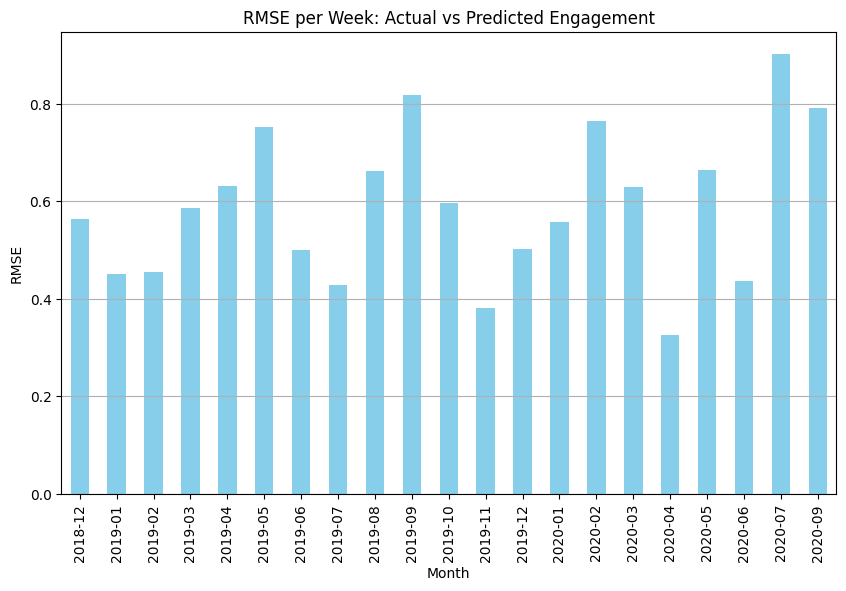

In [34]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from math import sqrt
# Merge on index
merged_data = pd.merge(test_pd, preds, left_index=True, right_index=True)

# Group by week and calculate RMSE for each week
merged_data['month'] = merged_data['post_date'].dt.to_period('M')
rmse_per_week = merged_data.groupby('month').apply(lambda x: sqrt(mean_squared_error(x['engagement'], x['prediction'])))

# Plotting RMSE as bars per week
plt.figure(figsize=(10, 6))
rmse_per_week.plot(kind='bar', color='skyblue')
plt.title('RMSE per Week: Actual vs Predicted Engagement')
plt.xlabel('Month')
plt.ylabel('RMSE')
plt.grid(axis='y')
plt.show()

## 3.5 Model Interpretation

### 3.5.1 Feature Importance of RF

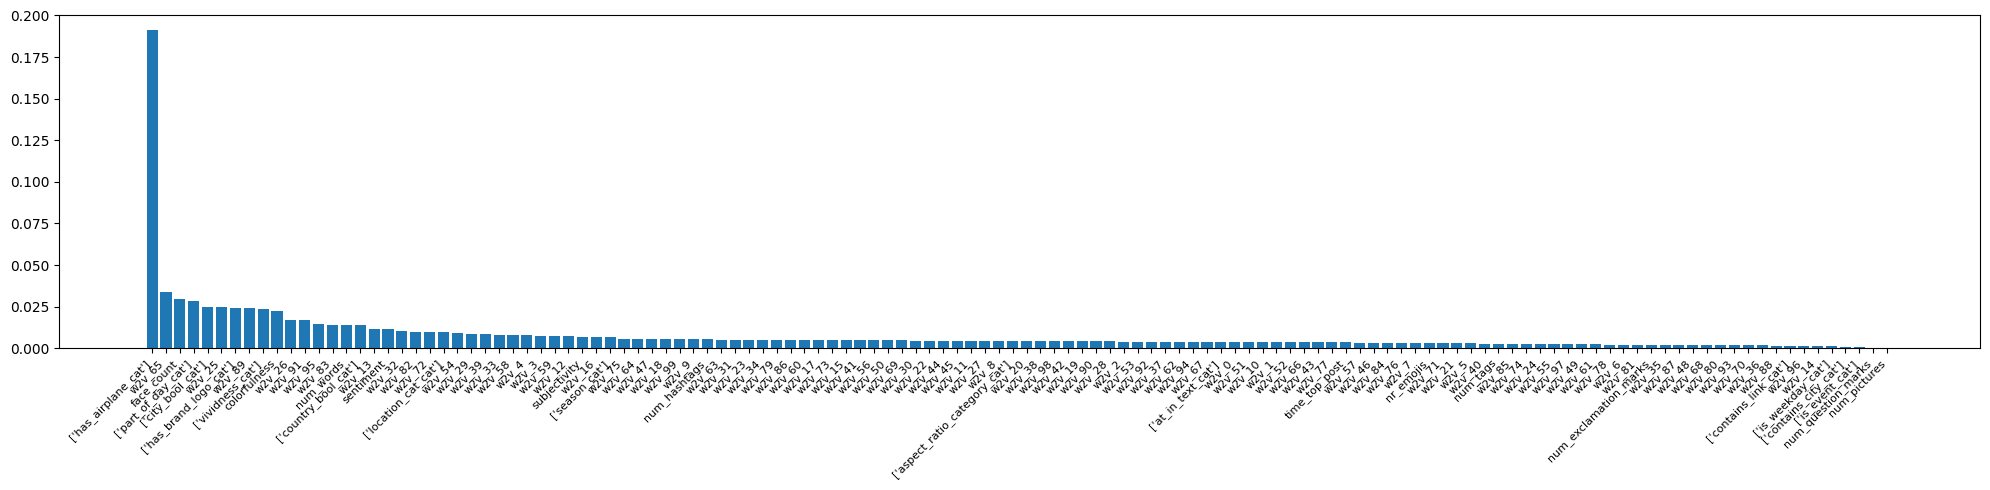

In [35]:
# Inspect feature importance
feature_importance = best_model_RF.featureImportances.toArray()

# Define all the features
all_feature_names =[[name + "_cat"] for name in cat_var]+ num_var +  ["w2v_" + str(i) for i in range(100)]

# Sort feature importances in descending order
sorted_indices = sorted(range(len(feature_importance)), key=lambda k: feature_importance[k], reverse=True)
sorted_importance = [feature_importance[i] for i in sorted_indices]
sorted_feature_names = [all_feature_names[i] for i in sorted_indices]

# Plot
plt.figure(figsize=(20, 5))  # Increased figure size
plt.bar(x=range(len(sorted_importance)), height=sorted_importance)
plt.xticks(range(len(sorted_importance)), sorted_feature_names, rotation=45, ha='right', fontsize=8)  # Adjusted rotation, alignment, and font size
plt.tight_layout()
plt.show()